# Kalman filter for Particule Tracing

Possible improvements: 
- Plot ellipsis confindence intervals
- Make real-time (video) and add controls -> challenging

## 1. Linear Model

Underlying Physics
- State $\textbf{x} = \begin{pmatrix}
x & y & v_x & v_y
\end{pmatrix} \in R^4$
- With charge $q$
- In electric field / gravity field / wind $\vec{E}$
- Is subject to accelation (force) $q\vec{E}$
- In time $dt$ it moves as 
$\textbf{x}(t+dt)=\begin{equation}
  \begin{cases}
      x & = x+dtv_x\\
      y & = y +dtv_y\\
      v_x & = v_x+qdtE_x(x,y)\\
      v_y & = v_x+qdtE_y(x,y)\\
    \end{cases}       
\end{equation}$
- Note: The electric field is linear in the position $E(x,y) = G\begin{pmatrix}
x\\ y
\end{pmatrix}$ with $G\in R^{2\times 2}$

Dynamical System Model (deterministic)

- Initialisation $x_0\in R^4$
- Transition $x_{t} = Fx_{t-1}+v_t$
- Process noise $v_t\sim \mathcal{N}(0,Q)$
- Transition matrix $F = \begin{pmatrix}
I_{2\times 2} & dt I_{2\times2}\\
qdtG & I_{2\times2}
\end{pmatrix}$

- Note: Process noise can be justified by the fact that there are irregularities in the magnetic field
- Note: Somehow dt should appear in $Q$ (like for a brownian motion). We leave that for later. 

Observation Model (GPS only: noisy position)

- Initial state prior $x_0 \sim \mathcal{N}(x_0, \Lambda_0)$ (optional -> set $\Lambda_0$ large to cancel effect)
- observation model $y_t = Hx_t+ v_t$
- new observation $y_t$
- obervation model $H = \begin{pmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{pmatrix}$
- observation noise $w_t \sim \mathcal{N}(0,R)$ (with $R = \sigma_{obs}I_{2\times2}$)
- Note: if we do not have access to the prior, we can assume the process is deterministic seqeunce (it only depends on the choice of $\mathbf{x}_0$) and it makes a non-bayesian setup

### 1.1 Global Variables and function

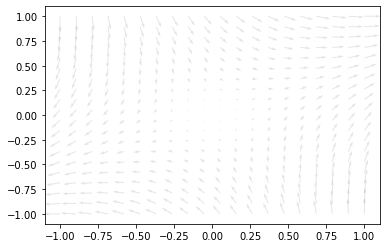

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## UNDERLYING PHYSICS

N = 30 #number of steps
dt = 0.1
q = 1

x_0 = np.array([-0.5,-0.5,0.5,1])

## TRANSITION MODEL

process_noise = 0 #std of  process noise, typical value is 0.01
Q = (process_noise)**2*np.identity(4)

F = np.array([
        [1,0,dt,0],
        [0,1,0,dt],
        [q*dt,q*dt,1,0],
        [q*dt,-q*dt,0,1]
    ])

## OBSERVATION MODEL 

Lambda_0 = (1e-2)*np.identity(4) # 1e10 make it contain no information /!\ setting to 1e100 produces unintended behavior

mes_noise = 0.1 #std mes noise
R = (mes_noise**2)*np.identity(2) #measurement noise

H = np.array([[1,0,0,0],[0,1,0,0]])

## PLOTTING

def plot_field():
    """
    Input:
        F: transition matrix
    
    Plots the associated field
    """
    A,B = np.meshgrid(np.linspace(-1,1,20),np.linspace(-1,1,20))
    G = F[2:,:2]
    u,v = np.tensordot(G,np.array([A,B]), axes = ([0],[0]))
    plt.quiver(A,B,u,v, alpha=0.1)
    
plot_field()

In [2]:
## REAL TRAJECTORY

def trajectory(x_0):
    """
    Input:
        x_0: initial state
    
    Output:
        X: Full state trajectory shape (T,4)
    """
    return np.array([np.linalg.matrix_power(F,i).dot(x_0)+np.random.multivariate_normal(mean = np.zeros(4),cov=Q) for i in range(N)])

X = trajectory(x_0)

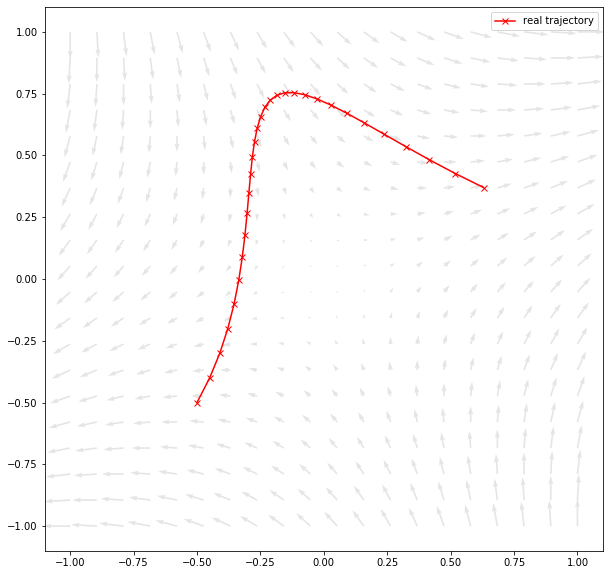

In [3]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="real trajectory")
plot_field()
plt.legend()
plt.show()

In [4]:
## OBSERVATION MODEL

def observation(X):
    """
    Input: 
        X: real trajectory, shape (T,4)
        
    Output: 
        Y: Observed trajectory (T,4)    
    """
    Z = [H.dot(x)+ np.random.multivariate_normal(mean = np.zeros(2),cov=R) for x in X]
    return np.array(Z)

Y = observation(X)

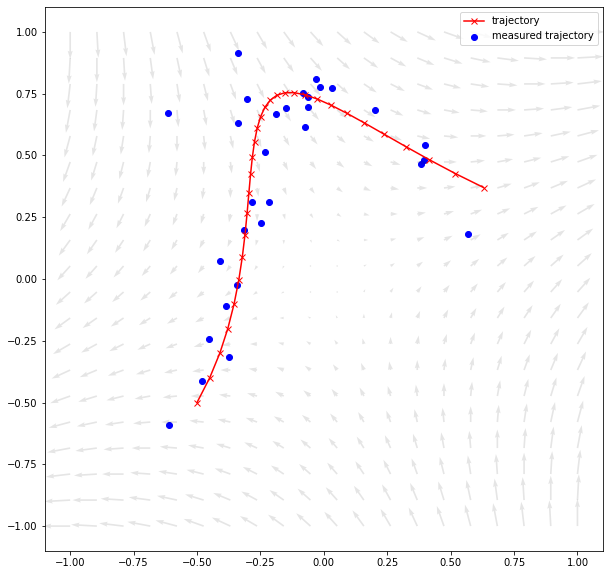

In [5]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.scatter(Y[:,0],Y[:,1], color ="blue",marker="o",label="measured trajectory")
plot_field()
plt.legend()
plt.show()

### 1.2 Running Average Filter "Alpha Beta filter"

Assuming no knowledge of the starting speed, we can attempt to reduce the measurement noise by avaraging the new measurement with most recent estimation

- alpha: regularization factor (belief that previous mesurement is still valid)
- beta: belief in new measurement

In [6]:
def rolling_filter(Y, alpha=0.5, beta=0.5):
    """
    INPUT: 
        Y: (N,2) observations
        alpha: regularization factor (belief in previous mesurement)
        beta: belief in new measurement
    
    OUTPUT
        Y_alpha_beta: (N,2) estimations
    """
    #initialisation
    Y_rolling = np.zeros((N,2))
    Y_rolling[0] = Y[0]

    #update
    for t in range(1,N):
        Y_rolling[t] = alpha*Y_rolling[t-1]+beta*Y[t]
    return Y_rolling

Y_rolling = rolling_filter(Y)

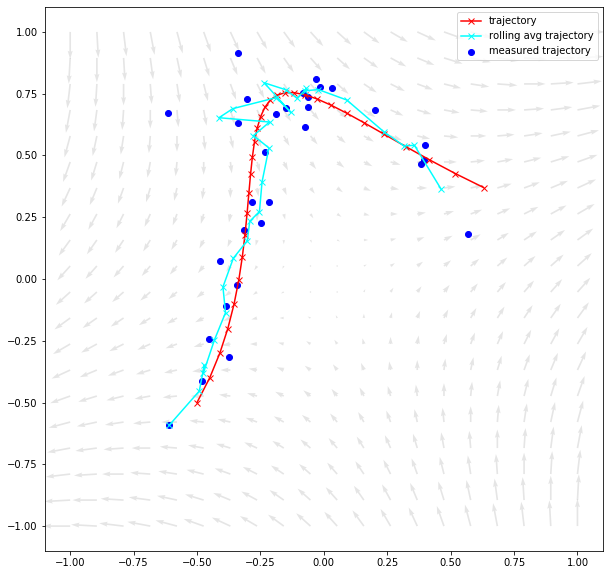

In [7]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.scatter(Y[:,0],Y[:,1], color ="blue",marker="o",label="measured trajectory")
plt.plot(Y_rolling[:,0],Y_rolling[:,1], color ="cyan",marker="x",label="rolling avg trajectory")
plot_field()
plt.legend()
plt.show()

### 1.3 MLE Filter

This filter assumes there is no process noise, and that it does not access an initialization prior.

The sequence $(x_i)_{i\leq N} = (F^ix_0)_{i\leq N}$ is therefore deterministic

Therefore, we observe positions $(y_i)_{i\leq N} = (HF^ix_0)_{i\leq N}$ follows distribution $\mathcal{N}\left(
\begin{pmatrix}
Hx_0\\
HFx_0\\
...\\
HF^Nx_0
\end{pmatrix},
\begin{pmatrix}
R,0,...\\
0,R,...\\
0,0,...\\
...,0,R\end{pmatrix}
\right)$

Finding $x_0$ (and therefore estimating the trajectory) becomes a maximum likelihood problem, and we have

$$x_0^{MLE} = \text{argmin}_{x\in R^4}||Ax-b||_2^2$$

where $A = \begin{pmatrix}
Hx_0\\
HFx_0\\
...\\
HF^Nx_0
\end{pmatrix}$
and $b = \begin{pmatrix}
y_0\\
y_1\\
...\\
y_N
\end{pmatrix}$

Note: 
- This will be done in a naive way (expliciting $A$) in the code below. Therefore it is not scalable with time (whereas the whole point of the Kalman filter is that computation time does not depend on current $t$)
- $x_i^{MLE} = A^ix_0^{MLE}$ so it really all boils down to estimating $x_0\in R^4$

In [8]:
def MLE_filter(Y):
    """
    INPUT: 
        Y: (N,2) observations
        
    OUTPUT: 
        Y_MLE: the maximum likelihood estimate at each time-step, assuming no process noise. 
    """
    Y_MLE = []
    for k in range(1,N+1):
        M = np.array([H.dot(np.linalg.matrix_power(F,i)) for i in range(k)])
        A = np.concatenate(M, axis=0)
        b = np.concatenate(Y[:k])
        x, residuals, rank, s = np.linalg.lstsq(A,b)
        Y_MLE.append(H.dot(np.linalg.matrix_power(F,k-1)).dot(x))
    return np.array(Y_MLE)

Y_MLE = MLE_filter(Y)

C:\Users\romai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


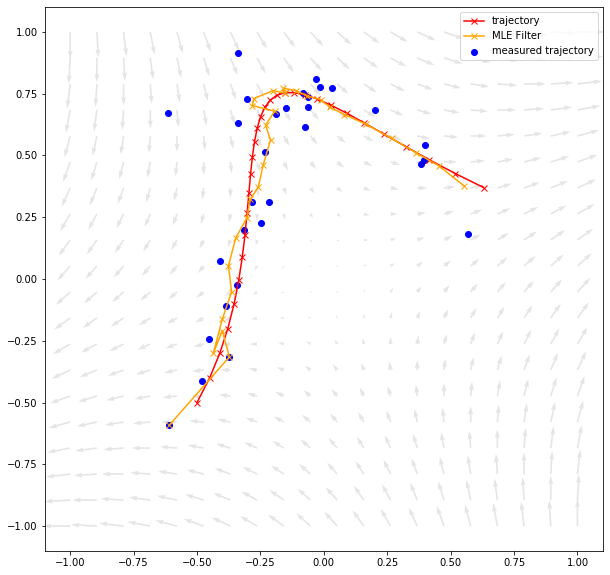

In [9]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory")
plt.scatter(Y[:,0],Y[:,1], color ="blue",marker="o",label="measured trajectory")
plt.plot(Y_MLE[:,0],Y_MLE[:,1], color ="orange",marker="x",label="MLE Filter")
plot_field()
plt.legend()
plt.show()

### 1.4 Kalman Filter

We implement the update rules that can be found here : https://en.wikipedia.org/wiki/Kalman_filter

Estimation Model
- prior estimated state $\hat{x}_{t|t-1}$
- prior estimated covariance $\hat{P}_{t|t-1}$
- posterior estimated state $\hat{x}_{t|t}$
- posterior estimated covariance $\hat{P}_{t|t}$

Prediction Rules
- a priori state estimation $\hat{x}_{t|t-1} = F\hat{x}_{t-1|t-1}$
- a priori covariance estimation $\hat{P}_{t|t-1} = F_{t-1}P_{t-1|t-1}F_{t-1}^T+Q$

Innovation Rules
- innovation estimation $i_t = z_t-H\hat{x}_{t|t-1}$
- innovation covariance $S_t = HP_{t|t-1}H^T+R$
- optimal Kalman gain $K_t = P_{t|t-1}H^TS_t^{-1}$
- a posteriori state estimation $\hat{x}_{t|t} = \hat{x}_{t|t-1}+K_ti_t$
- a posteriori covariance estimation $P_{t|t} = (I-K_tH)P_{t|t-1}$

Note:
- To account for the fact that we have no initial knowledge of the speed, we give a very large variance to the initial speed estimate (like $1e10$)
- It is reassuring to observe that, under these conditions, the Kalman filter has the exact same behavior as the "MLE filter"

In [11]:
## Linear Kalman Filter

def update_kalman(x_h_prev,P_prev,y):
    """
    subroutine of kalman_filter
    
    INPUT:
        x_h_prev: previous estimate of state
        P_prev: previous covariance matrix
        y: new measurement
    
    OUTPUT: 
        x_h_posteriori: next estimate of the state
        P_posteriori: covariance estimate matrix    
    """    
    x_h_priori = F.dot(x_h_prev) #a priori state estimation
    P_priori = F.dot(P_prev).dot(F.T)+Q #a priori covariance estimation
    i = y-H.dot(x_h_priori) #innovation
    S = H.dot(P_priori).dot(H.T)+R #innovation covariance
    K = P_priori.dot(H.T).dot(np.linalg.inv(S)) #optimal Kalman gain
    x_h_posteriori = x_h_priori + K.dot(i)
    P_posteriori = (np.identity(4)-K.dot(H)).dot(P_priori)
    return x_h_posteriori,P_posteriori

def kalman_filter(Y):
    """
    INPUT: 
        Y: (N,2) noisy trajectory
    
    OUTPUT: 
        X_kalman: (N,4) kalman filter estimate    
    """
    # Initialisation (tricky cause we must inject the prior)
    i = Y[0] - H.dot(x_0)
    S = H.dot(Lambda_0).dot(H.T)+R
    K = Lambda_0.dot(H.T).dot(np.linalg.inv(S))
    X_kalman = [x_0+K.dot(i)] 
    P_kalman = [(np.identity(4)-K.dot(H)).dot(Lambda_0)]

    # Updates
    for t in range(1,N):
        res = update_kalman(X_kalman[-1],P_kalman[-1],Y[t])
        X_kalman.append(res[0])
        P_kalman.append(res[1])
    
    # Remove the initialisation
    X_kalman = np.array(X_kalman)[:]
    
    return X_kalman

X_kalman = kalman_filter(Y)

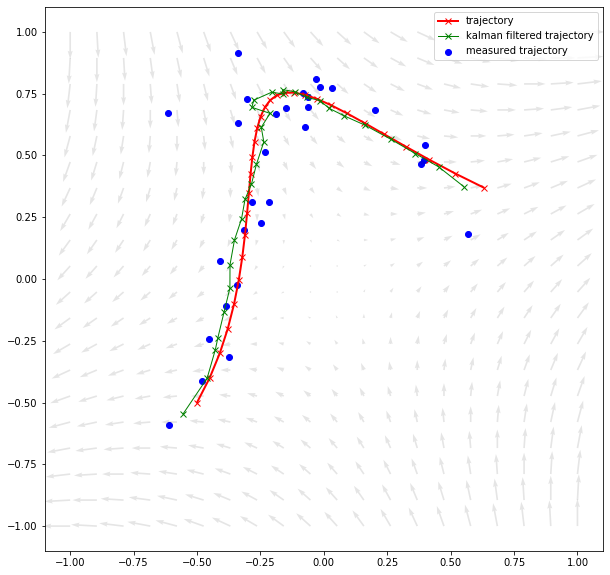

In [12]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory", linewidth=2)#linestyle ="dashed",
plt.scatter(Y[:,0],Y[:,1], color ="blue",marker="o",label="measured trajectory")
plt.plot(X_kalman[:,0],X_kalman[:,1], color ="green",marker="x",label="kalman filtered trajectory", linewidth=1)
plot_field()
plt.legend()
plt.show()

## 1.4 Comparison

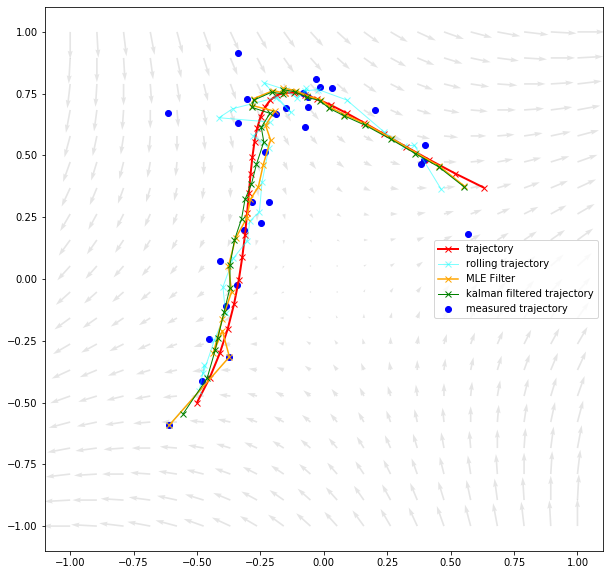

In [13]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory", linewidth=2)#linestyle ="dashed",
plt.scatter(Y[:,0],Y[:,1], color ="blue",marker="o",label="measured trajectory")
plt.plot(Y_rolling[:,0],Y_rolling[:,1], color ="cyan",marker="x",label="rolling trajectory", linewidth=1, alpha =0.5)
plt.plot(Y_MLE[:,0],Y_MLE[:,1], color ="orange",marker="x",label="MLE Filter")
plt.plot(X_kalman[:,0],X_kalman[:,1], color ="green",marker="x",label="kalman filtered trajectory", linewidth=1)
plot_field()
plt.legend()
plt.show()

In [14]:
def mse(Y_h):
    """
    INPUT:
        Y_h: (T,2) estimate of the position
    
    OUTPUT
        MSE with true position
    """
    return np.mean((X[:,:2]-Y_h)**2)

pd.DataFrame({"Estimation Strategy":["Noisy","Rolling","MLE","Kalman"], "MSE":[mse(Y), mse(Y_rolling),mse(Y_MLE),mse(X_kalman[:,:2])]})

,Estimation Strategy,MSE
0,Noisy,0.010466
1,Rolling,0.009072
2,MLE,0.002321
3,Kalman,0.001343


## 2. Exploring different setups

### 2.1 Non-bayesian setup: unkown initalisation

We explore here the case where we have no prior on $x_0$

This can be encoded in $\Lambda_0$ taking large values (no confidence in prior)

In this setup, MLE filter and Kalman filter perform the same estimator !!

In [15]:
Lambda_0 = (1e10)*np.identity(4)

Y_rolling = rolling_filter(Y)
Y_MLE = MLE_filter(Y)
X_kalman = kalman_filter(Y)


C:\Users\romai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


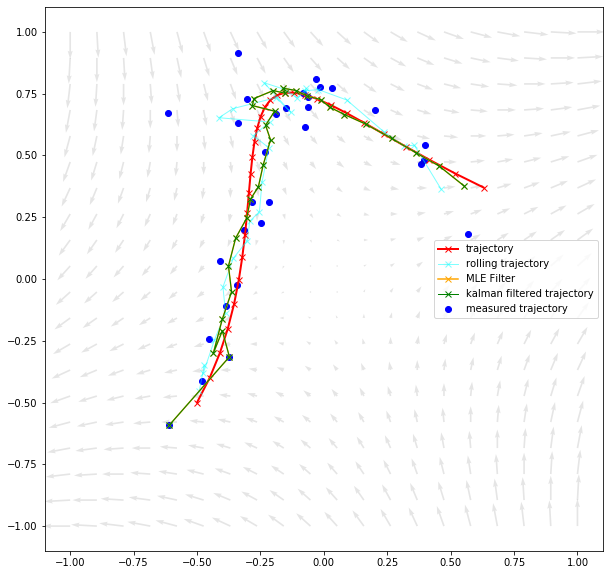

In [16]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory", linewidth=2)#linestyle ="dashed",
plt.scatter(Y[:,0],Y[:,1], color ="blue",marker="o",label="measured trajectory")
plt.plot(Y_rolling[:,0],Y_rolling[:,1], color ="cyan",marker="x",label="rolling trajectory", linewidth=1, alpha =0.5)
plt.plot(Y_MLE[:,0],Y_MLE[:,1], color ="orange",marker="x",label="MLE Filter")
plt.plot(X_kalman[:,0],X_kalman[:,1], color ="green",marker="x",label="kalman filtered trajectory", linewidth=1)
plot_field()
plt.legend()
plt.show()

### 2.2 Different initialisation

In [18]:
N=40
Lambda_0 = (1e-2)*np.identity(4)
x_0 = np.array([-0.1,0.3,0,0])

X = trajectory(x_0)
Y = observation(X)
Y_rolling = rolling_filter(Y)
Y_MLE = MLE_filter(Y)
X_kalman = kalman_filter(Y)

C:\Users\romai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


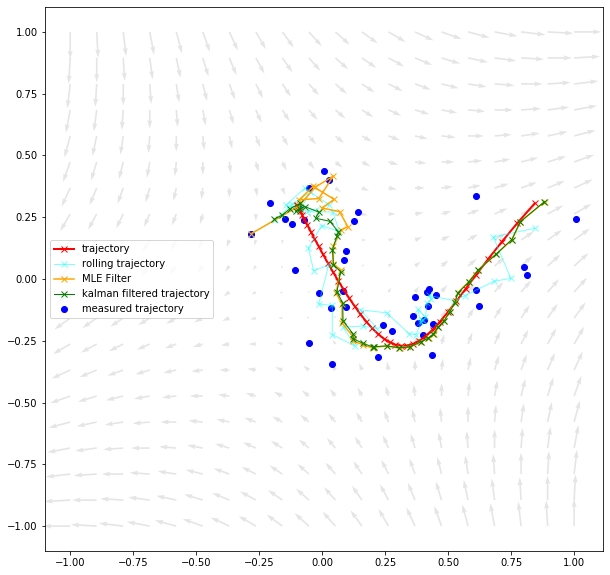

In [19]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory", linewidth=2)#linestyle ="dashed",
plt.scatter(Y[:,0],Y[:,1], color ="blue",marker="o",label="measured trajectory")
plt.plot(Y_rolling[:,0],Y_rolling[:,1], color ="cyan",marker="x",label="rolling trajectory", linewidth=1, alpha =0.5)
plt.plot(Y_MLE[:,0],Y_MLE[:,1], color ="orange",marker="x",label="MLE Filter")
plt.plot(X_kalman[:,0],X_kalman[:,1], color ="green",marker="x",label="kalman filtered trajectory", linewidth=1)
plot_field()
plt.legend()
plt.show()

In [20]:
pd.DataFrame({"Estimation Strategy":["Noisy","Rolling","MLE","Kalman"], "MSE":[mse(Y), mse(Y_rolling),mse(Y_MLE),mse(X_kalman[:,:2])]})

,Estimation Strategy,MSE
0,Noisy,0.010815
1,Rolling,0.005319
2,MLE,0.003693
3,Kalman,0.001585


## 3. Nonlinear Model

- Process model $x_{t+1} = f(x_t) + v_t$
- Transition matrix  changing with time $F_t = \partial_xf(x_{t|t})$
- Observation model $H$ does not change with time

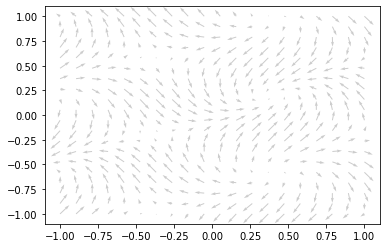

In [21]:
# Vector fields 
def circle(x,y):
    return np.array([-y/np.sqrt(x**2 + y**2),x/np.sqrt(x**2 + y**2)])

def delta(x,y):
    return np.array([((y+1)**2)*(x/(abs(x)+0.2)),0])#np.array([5*x*y,2-4*(abs(y+0.5)+y+0.5)])

def linear_field(x,y):
    return np.array((x+y,x-y))

def cos_field(x,y):
    return np.array([np.cos(2*x+2*2*y), np.sin(2*x-2*2*y) ])

def plot_field():
    A,B = np.meshgrid(np.linspace(-1,1,20),np.linspace(-1,1,20))
    u,v = field(A,B)
    plt.quiver(A,B,u,v, alpha = 0.2)
    
    
field = cos_field
    
plot_field()

In [22]:
def f(x):
    next_x = x.copy()
    next_x[0:2] = x[0:2]+dt*x[2:4]
    next_x[2:4] = x[2:4]+q*dt*field(x[0],x[1])
    speed = next_x[2:]
    next_x[2:] = (1-2*dt*np.linalg.norm(speed)**2)*speed #Capping speed with quadratic friction. 
    return next_x

def gradient(f,x):
    """
    INPUT: 
        f: differentiable function from R^4 -> R^4
        x: point of differentiability
    
    OUTPUT
        F: local gradient
        
    NOTE: 
        This is a discrete version, what matters is the linearization of f bteween one state and the next, 
        this is how we choose delta
    """
    delta = np.linalg.norm(x-f(x))/1e5
    F = np.zeros((4,4))
    for i in range(4):
        dx = np.zeros(4)
        dx[i]=delta
        F[:,i]= (f(x+dx)-f(x-dx))/(2*delta)
    return F

In [23]:
#gradient(f, np.array([0,0,0,0]))

In [26]:
N=60
q=1
process_noise = 0.02 #std of  process noise, typical value is 0.01
Q = (process_noise)**2*np.identity(4)
#x_0 = np.array([-0.5,-0.5,0.1,1.2]) #Good initialization for circle: There is a near discontinuity at 1.05
#x_0 = np.array([-0.9,-0.9,0.5,0]) #Good initialization for cos_field, T=25
x_0 = np.array([0,-0.9,0,0.75]) # Good for initialisation with delta field T=25
#x_0 = np.array([-0.4,0.6,0.2,-0.2]) # Also nice for cos_field

def trajectory(x_0,N):
    """
    Input:
        x_0: initial state
        T: number of timesteps
    
    Output:
        X: Full state trajectory shape (N,4)
    """
    X = [x_0]
    for t in range(1,N):
        X.append(f(X[t-1])+np.random.multivariate_normal(mean = np.zeros(4),cov=Q))
    return np.array(X)

X = trajectory(x_0,N)
Y = observation(X)
Y_rolling = rolling_filter(Y)

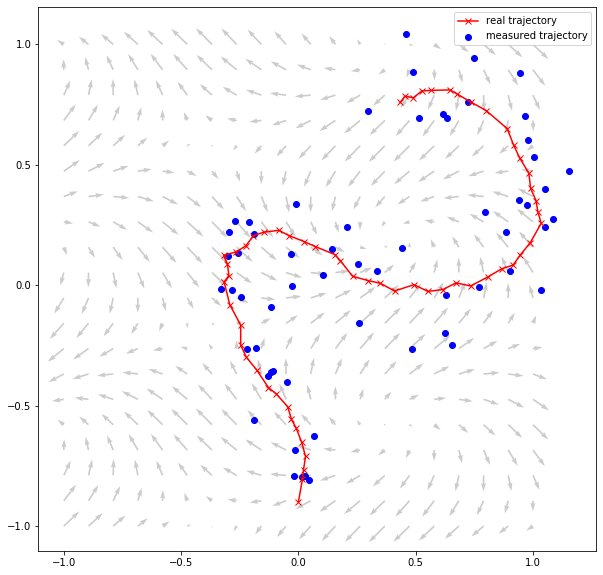

In [27]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="real trajectory")
plt.scatter(Y[:,0],Y[:,1], color ="blue",marker="o",label="measured trajectory")
#plt.plot(Y_rolling[:,0],Y_rolling[:,1], color ="cyan",marker="x",label="rolling trajectory", linewidth=1, alpha =0.5)
plot_field()
plt.legend()
plt.show()

In [28]:
Y_rolling = rolling_filter(Y)

In [30]:
## Extended Kalman Filter

def update_kalman(x_h_prev,P_prev,y):
    """
    subroutine of kalman_filter
    
    INPUT:
        x_h_prev: previous estimate of state
        P_prev: previous covariance matrix
        y: new measurement
    
    OUTPUT: 
        x_h_posteriori: next estimate of the state
        P_posteriori: covariance estimate matrix    
    """
    F = gradient(f,x_h_prev)
    x_h_priori = f(x_h_prev) #a priori state estimation
    P_priori = F.dot(P_prev).dot(F.T)+Q #a priori covariance estimation
    i = y-H.dot(x_h_priori) #innovation
    S = H.dot(P_priori).dot(H.T)+R #innovation covariance
    K = P_priori.dot(H.T).dot(np.linalg.inv(S)) #optimal Kalman gain
    x_h_posteriori = x_h_priori + K.dot(i)
    P_posteriori = (np.identity(4)-K.dot(H)).dot(P_priori)
    return x_h_posteriori,P_posteriori

def kalman_filter(Y):
    """
    INPUT: 
        Y: (N,2) noisy trajectory
    
    OUTPUT: 
        X_kalman: (N,4) kalman filter estimate    
    """
    # Initialisation (tricky cause we must inject the prior)
    i = Y[0] - H.dot(x_0)
    S = H.dot(Lambda_0).dot(H.T)+R
    K = Lambda_0.dot(H.T).dot(np.linalg.inv(S))
    X_kalman = [x_0+K.dot(i)] 
    P_kalman = [(np.identity(4)-K.dot(H)).dot(Lambda_0)]

    # Updates
    for t in range(1,N):
        res = update_kalman(X_kalman[-1],P_kalman[-1],Y[t])
        X_kalman.append(res[0])
        P_kalman.append(res[1])
    
    # Remove the initialisation
    X_kalman = np.array(X_kalman)[:]
    
    return X_kalman

X_kalman = kalman_filter(Y)

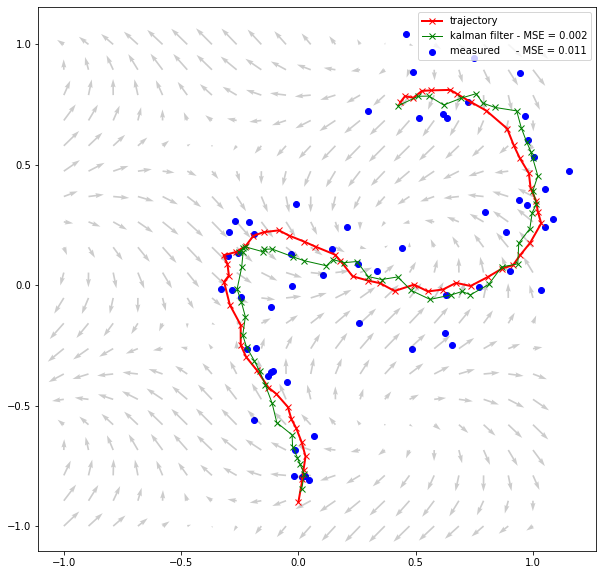

In [31]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory", linewidth=2)#linestyle ="dashed",
plt.scatter(Y[:,0],Y[:,1], color ="blue",marker="o",label="measured     - MSE = "+ str(round(mse(Y),3)))
#plt.plot(Y_rolling[:,0],Y_rolling[:,1], color ="cyan",marker="x",label="rolling filter   - MSE = "+ str(round(mse(Y_rolling),3)), linewidth=1, alpha =0.5)
plt.plot(X_kalman[:,0],X_kalman[:,1], color ="green",marker="x",label="kalman filter - MSE = "+ str(round(mse(X_kalman[:,:2]),3)), linewidth=1)
plot_field()
plt.legend()
plt.show()

# 4. Unscented Kalman Filter

# 5. Particle filter

We refer to lecture 19 - Particle filter

- p_x_priori: refers to the estimate distribution of $x_t$ conditionned on $y_0, ..., y_{t-1}$
- p_x_posteriori: refers to the estimate distribution of $x_t$ conditioned on $y_0, ..., y_t$
- K: fixed number of particules to sample from 

Discrete distributions will be encoded by two lists (particles, proability) 

In [32]:
def importance_sampling(q_prop, p_tilde):
    """
    INPUT: 
        q: Proposal distribution - encoded as tuple of two lists: (outcomes, weights)
        p_tilde: desired weighting of the outcomes, encoded as a function
    
    GLOBAL:
        K: number of particles
        
    OUTPUT: 
        p_posterior: the distribution p(x|y) - encoded as tuple of two lists: (outcomes, weights)
    """
    n = len(q_prop[0])
    particles = np.random.choice(n,p = q_prop[1], size = K)
    weights = np.array([p_tilde(q_prop[0][i])/q_prop[1][i] for i in particles])
    weights = weights/weights.sum()
    ## NOTE: could add a module to make sure all particles are different
    return np.array(q_prop[0])[particles], weights

In [33]:
K=3
q_prop = [4,2],[0.5,0.5]
p_tilde = lambda x: 2/(x**2)

importance_sampling(q_prop, p_tilde)

(array([4, 4, 2]), array([0.16666667, 0.16666667, 0.66666667]))

In [35]:
def particle_filtering(Y):
    """
    INPUT: 
        Y: sequence of observations
    
    GLOBAL
        x_0: estimate of mean
        Lambda_0: estimate of covariance
        K: number of particles
        R: noise model is still assumed gaussian
    
    OUTPUT
        distributions: list containing the discrete distribution of the data at each time step
    """
    distributions = []
    
    # Iinitialisation
    particles = np.random.multivariate_normal(mean=x_0,cov=Lambda_0, size = K)
    weights = np.ones(K)/K
    q_prop = particles, weights
    p_tilde = lambda x: np.exp(-0.5*((H.dot(x)-Y[0]).T).dot(np.linalg.inv(R)).dot(H.dot(x)-Y[0]))
    weights = weights*np.array([p_tilde(part) for part in particles])
    weights = weights/weights.sum()
    q_posteriori = particles, weights
    distributions.append(q_posteriori)
    
    # RECURSION
    for t in range(1,N):
        q_prev = distributions[-1]
        
        #RESAMPLING
        i_particles = np.random.choice(K,p = q_prev[1], size = K)
        weights = np.ones(K)/K
        particles = np.array(particles)[i_particles]
        
        #PRIORI
        particles = [f(part)+np.random.multivariate_normal(mean = np.zeros(4), cov = Q) for part in particles]
        
        #POSTERIORI
        p_tilde = lambda x: np.exp(-0.5*((H.dot(x)-Y[t]).T).dot(np.linalg.inv(R)).dot(H.dot(x)-Y[t]))
        weights = weights*np.array([p_tilde(part) for part in particles])
        weights = weights/weights.sum()
        q_posteriori = particles, weights
        distributions.append(q_posteriori)
    
    return distributions

In [36]:
K=500
sol = particle_filtering(Y)

In [37]:
def expectation(distribution):
    particles, weights = distribution
    avg = np.zeros(4)
    n = len(particles)

    for i in range(n):
        avg+=weights[i]*particles[i]
    
    return avg

In [38]:
X_part = np.array([expectation(distribution) for distribution in sol])

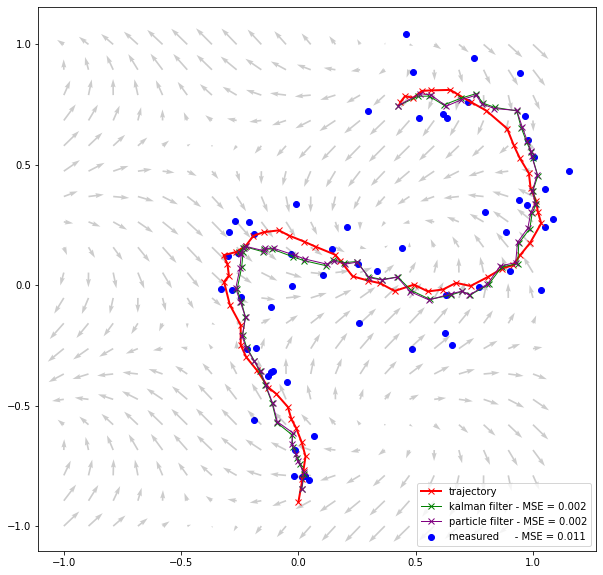

In [39]:
plt.figure(figsize=(10,10))
plt.plot(X[:,0],X[:,1], color ="red",marker="x",label="trajectory", linewidth=2)#linestyle ="dashed",
plt.scatter(Y[:,0],Y[:,1], color ="blue",marker="o",label="measured     - MSE = "+ str(round(mse(Y),3)))
#plt.plot(Y_rolling[:,0],Y_rolling[:,1], color ="cyan",marker="x",label="rolling filter   - MSE = "+ str(round(mse(Y_rolling),3)), linewidth=1, alpha =0.5)
plt.plot(X_kalman[:,0],X_kalman[:,1], color ="green",marker="x",label="kalman filter - MSE = "+ str(round(mse(X_kalman[:,:2]),3)), linewidth=1)
plt.plot(X_part[:,0],X_part[:,1], color ="purple",marker="x",label="particle filter - MSE = "+ str(round(mse(X_part[:,:2]),3)), linewidth=1)
plot_field()
plt.legend()
plt.show()